In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
# 필요한 라이브러리 임포트
import os
# CUDA 장치 설정 (특정 GPU 사용)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
import importlib 


# 다중 프로세싱 시작 방식 설정 (DataLoader 사용 시)
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    print("Multiprocessing start method already set. Please restart the runtime.")

# 사용자 정의 모듈 임포트 (기존 임포트된 모듈 제거 및 새로 임포트)
try:
    # 세션에 저장된 모듈 제거
    if "models" in sys.modules:
        importlib.reload(sys.modules["models"])
    if "Segdataset" in sys.modules:
        importlib.reload(sys.modules["Segdataset"])
    if "utils" in sys.modules:
        importlib.reload(sys.modules["utils"])

    # 사용자 정의 모듈 임포트
    from models import *
    from Segdataset import SegDataset, load_mfcc_and_labels  # 데이터셋 클래스 및 파일 읽기 함수 가져오기
    from utils import plot_fold_performance  # 모델 성능 시각화 함수 가져오기

except ImportError as e:
    sys.exit(f"Failed to import required modules: {e}")

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


In [4]:
class Args:
    def __init__(self):
        # 데이터 경로 설정
        self.data_root = '/workspace/dataset/free_talking_datasets/mfcc_split_voice_train'  # MFCC 파일이 저장된 루트 디렉토리
        self.save_root = '/workspace/UndergraduateResearchAssistant/GraduateProject/code/EmotionFreeTaking/checkpoints/CNN'  # 모델 체크포인트를 저장할 경로

        # 학습 설정
        self.epoch = 100  # 학습 에포크 수
        self.lr = 3e-4  # 학습률
        self.batch_size = 350  # 배치 크기 배치 사이즈 16 -> 1600으로 상향 조절. 데이터 수 100배 넘게 되었으므로
        self.num_workers = 2  # DataLoader에서 사용할 병렬 워커 수

        # 랜덤 시드 및 특성 설정
        self.random_seed = 1  # 재현 가능성을 위한 랜덤 시드
        self.n_mfcc = 16  # MFCC 특성 차원 수

        # K-Fold 교차 검증 설정
        self.n_splits = 5  # 교차 검증을 위한 K-fold 개수

        # 모델 설정 (CNN, RNN, Transformer 중 선택)
        self.model_type = 'CNN'  # 사용할 모델 타입 ('CNN', 'RNN', 'Transformer' 중 하나)

# 설정 인스턴스 생성
opt = Args()


In [5]:
# 모델 선택 및 초기화
if opt.model_type == 'CNN':
    model = CNN().to(device)
elif opt.model_type == 'RNN':
    model = RNN(n_mfcc=opt.n_mfcc).to(device)
elif opt.model_type == 'Transformer':
    model = Transformer(n_mfcc=opt.n_mfcc).to(device)
else:
    raise ValueError(f"Invalid model type specified: {opt.model_type}")

print(model)

CNN(
  (cnn): Sequential(
    (0): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): AdaptiveAvgPool1d(output_size=1)
  )
  (fc1): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [6]:
# MFCC 특징과 감정 레이블 로드
mfcc_list, emotion_list = load_mfcc_and_labels(opt.data_root) # GPU에 데이터 적제 되어 있음

# K-Fold 설정
kf = KFold(n_splits=opt.n_splits, shuffle=True, random_state=opt.random_seed)

Loading MFCC files: 100%|██████████| 263198/263198 [01:40<00:00, 2611.60file/s]


Fold 1/5
Dataset loaded with 210558 samples.
Dataset loaded with 52640 samples.
Fold 1 | Epoch 0 | Train Loss: 1.0339806011433212 | Val Loss: 1.029044628540675 | Val Accuracy: 0.7458476190476191
Fold 1 | Epoch 1 | Train Loss: 1.0197087074079847 | Val Loss: 1.013893706003825 | Val Accuracy: 0.7231619047619048
Fold 1 | Epoch 2 | Train Loss: 1.0119145010751416 | Val Loss: 1.0109603730837504 | Val Accuracy: 0.7334095238095238
Fold 1 | Epoch 3 | Train Loss: 1.0075026776350278 | Val Loss: 1.0060876182715097 | Val Accuracy: 0.7084
Fold 1 | Epoch 4 | Train Loss: 1.0021559105141586 | Val Loss: 1.017283429702123 | Val Accuracy: 0.753352380952381
Fold 1 | Epoch 5 | Train Loss: 0.9972526827786806 | Val Loss: 0.9987495108445485 | Val Accuracy: 0.7257714285714286
Fold 1 | Epoch 6 | Train Loss: 0.9937830635791214 | Val Loss: 0.9930048966407776 | Val Accuracy: 0.7067619047619048
Fold 1 | Epoch 7 | Train Loss: 0.9908502586867766 | Val Loss: 0.9954219969113668 | Val Accuracy: 0.7112952380952381
Fold 1 |

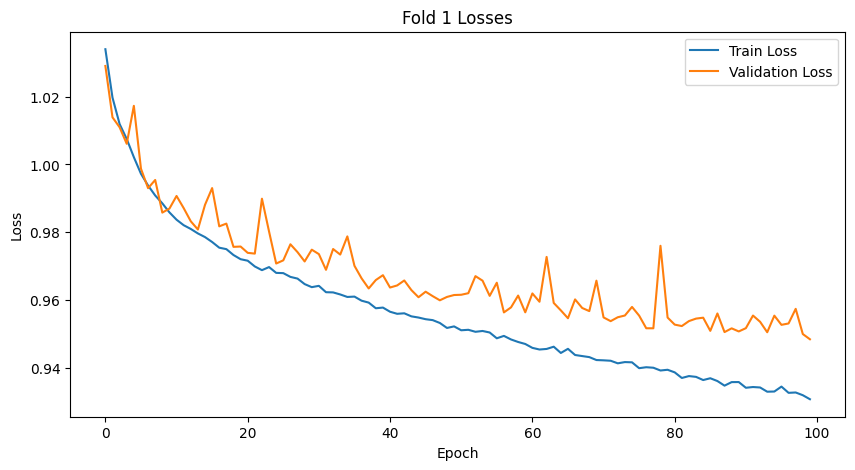

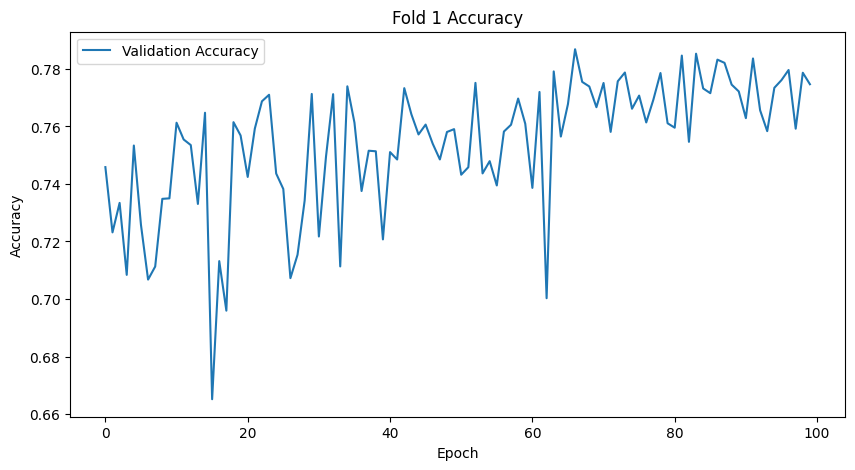

Fold 2/5
Dataset loaded with 210558 samples.
Dataset loaded with 52640 samples.
Fold 2 | Epoch 0 | Train Loss: 1.036422207827576 | Val Loss: 1.0309416977564494 | Val Accuracy: 0.7409714285714286
Fold 2 | Epoch 1 | Train Loss: 1.0199901007376178 | Val Loss: 1.0237574652830759 | Val Accuracy: 0.737352380952381
Fold 2 | Epoch 2 | Train Loss: 1.0133457211607109 | Val Loss: 1.0261544052759806 | Val Accuracy: 0.5995238095238096
Fold 2 | Epoch 3 | Train Loss: 1.0078431651516881 | Val Loss: 1.0019956549008688 | Val Accuracy: 0.7031428571428572
Fold 2 | Epoch 4 | Train Loss: 1.0028264613794209 | Val Loss: 1.0019509641329447 | Val Accuracy: 0.6872761904761905
Fold 2 | Epoch 5 | Train Loss: 0.9988869927488825 | Val Loss: 0.998254611492157 | Val Accuracy: 0.6930857142857143
Fold 2 | Epoch 6 | Train Loss: 0.9954430578949051 | Val Loss: 0.9983892599741618 | Val Accuracy: 0.6944380952380952
Fold 2 | Epoch 7 | Train Loss: 0.992656111320521 | Val Loss: 0.9919314547379812 | Val Accuracy: 0.7145714285714

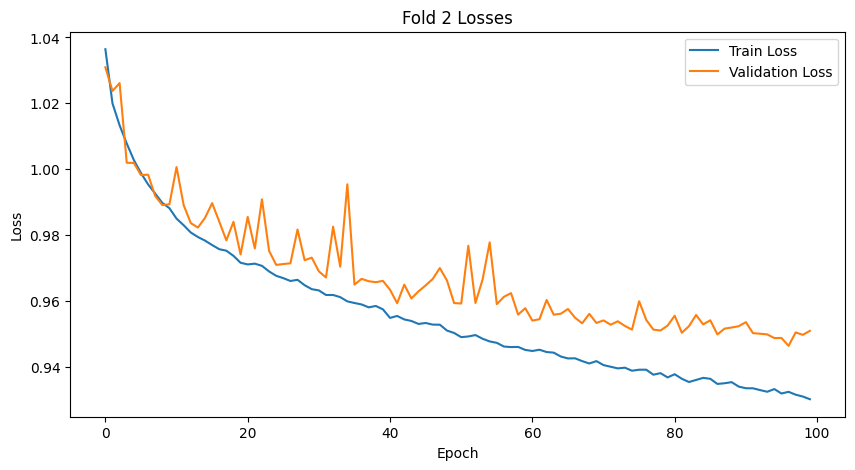

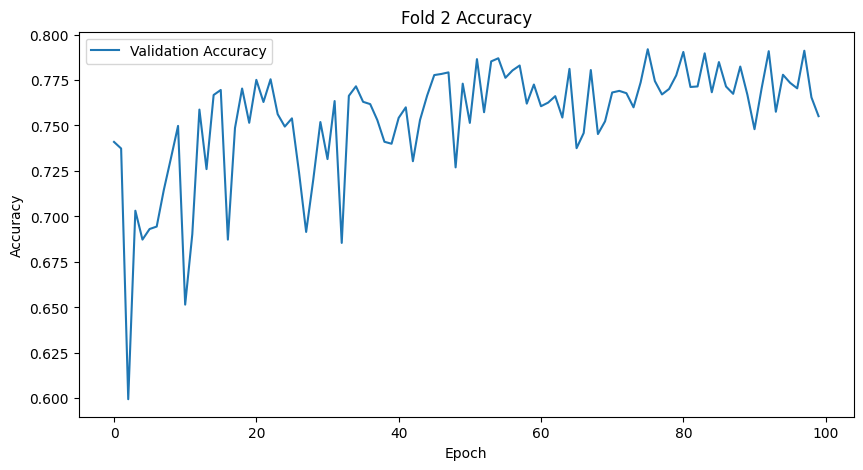

Fold 3/5
Dataset loaded with 210558 samples.
Dataset loaded with 52640 samples.
Fold 3 | Epoch 0 | Train Loss: 1.032047237016992 | Val Loss: 1.0170840263366698 | Val Accuracy: 0.7227619047619047
Fold 3 | Epoch 1 | Train Loss: 1.018141412199436 | Val Loss: 1.0103942513465882 | Val Accuracy: 0.6916952380952381
Fold 3 | Epoch 2 | Train Loss: 1.0129367065509027 | Val Loss: 1.0064261440436046 | Val Accuracy: 0.6813904761904762
Fold 3 | Epoch 3 | Train Loss: 1.0061113354370321 | Val Loss: 1.0005041102568308 | Val Accuracy: 0.7354857142857143
Fold 3 | Epoch 4 | Train Loss: 1.0014745800348368 | Val Loss: 0.996644803682963 | Val Accuracy: 0.6929904761904762
Fold 3 | Epoch 5 | Train Loss: 0.9975500301196055 | Val Loss: 1.0002543262640635 | Val Accuracy: 0.7623809523809524
Fold 3 | Epoch 6 | Train Loss: 0.9931747337149305 | Val Loss: 0.9894821476936341 | Val Accuracy: 0.7423428571428572
Fold 3 | Epoch 7 | Train Loss: 0.9899333242370364 | Val Loss: 0.9967502272129058 | Val Accuracy: 0.759676190476

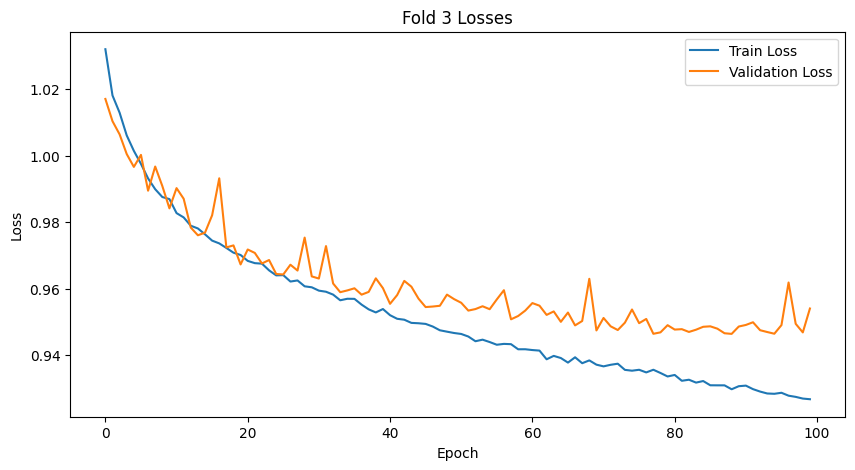

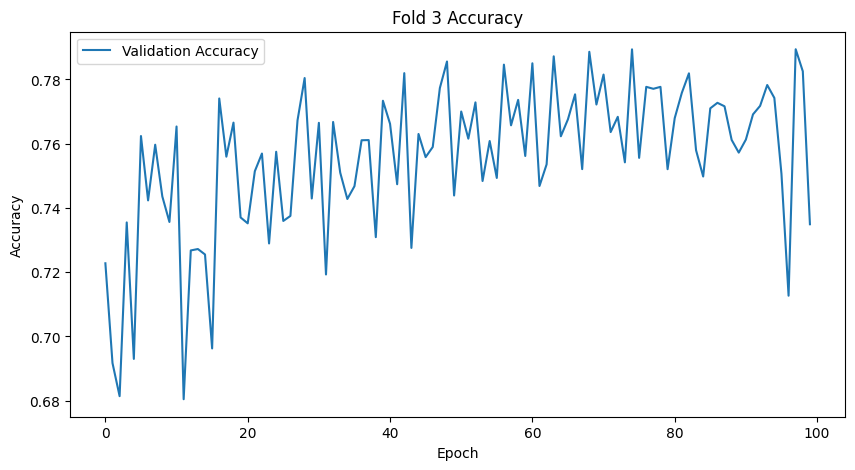

Fold 4/5
Dataset loaded with 210559 samples.
Dataset loaded with 52639 samples.
Fold 4 | Epoch 0 | Train Loss: 1.0311866451222171 | Val Loss: 1.0172557107607523 | Val Accuracy: 0.7051809523809524
Fold 4 | Epoch 1 | Train Loss: 1.0156070957961376 | Val Loss: 1.0156164411703745 | Val Accuracy: 0.6553714285714286
Fold 4 | Epoch 2 | Train Loss: 1.0089917405076114 | Val Loss: 1.0063424444198608 | Val Accuracy: 0.6859047619047619
Fold 4 | Epoch 3 | Train Loss: 1.0034734808069696 | Val Loss: 0.9986398832003276 | Val Accuracy: 0.7096190476190476
Fold 4 | Epoch 4 | Train Loss: 0.9985222217445564 | Val Loss: 0.999570775826772 | Val Accuracy: 0.6772
Fold 4 | Epoch 5 | Train Loss: 0.995400509501059 | Val Loss: 0.9938082508246104 | Val Accuracy: 0.7269142857142857
Fold 4 | Epoch 6 | Train Loss: 0.9929703196352612 | Val Loss: 0.9908287115891774 | Val Accuracy: 0.7105714285714285
Fold 4 | Epoch 7 | Train Loss: 0.989666995212758 | Val Loss: 0.987415832678477 | Val Accuracy: 0.7222285714285714
Fold 4 |

[W1003 13:11:19.957660363 CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]
[W1003 13:11:19.027168555 CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]


KeyboardInterrupt: 

In [7]:
# 학습 및 검증 루프 시작
for fold, (train_idx, val_idx) in enumerate(kf.split(mfcc_list)):
    print(f"Fold {fold + 1}/{opt.n_splits}")

    # 모델 초기화
    if opt.model_type == 'CNN':
        model = CNN().to(device)
    elif opt.model_type == 'RNN':
        model = RNN(n_mfcc=opt.n_mfcc).to(device)
    elif opt.model_type == 'Transformer':
        model = Transformer(n_mfcc=opt.n_mfcc).to(device)
    else:
        raise ValueError(f"Invalid model type: {opt.model_type}")
    

    # 학습/검증 데이터로 쪼개기
    train_mfcc = [mfcc_list[i] for i in train_idx]
    train_emotion = [emotion_list[i] for i in train_idx]
    val_mfcc = [mfcc_list[i] for i in val_idx]
    val_emotion = [emotion_list[i] for i in val_idx]

    train_set = SegDataset(train_mfcc, train_emotion)
    val_set = SegDataset(val_mfcc, val_emotion)

    # 데이터 로더 생성 (각 배치 단위로 데이터를 GPU에 올리기)
    train_loader = DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=opt.num_workers)
    val_loader = DataLoader(val_set, batch_size=opt.batch_size, shuffle=False, drop_last=True, num_workers=opt.num_workers)

    # 각 fold에 따라 pos_weight 동적으로 설정
    num_pos = sum(em == 1 for em in train_emotion)
    num_neg = sum(em == 0 for em in train_emotion)
    pos_weight = torch.tensor([num_neg / num_pos]).to(device) if num_pos > 0 else torch.tensor([1.0]).to(device)

    # 손실 함수 및 옵티마이저 선언
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
    optimizer = optim.Adam(model.parameters(), lr=opt.lr)

    # 현재 폴드 값들 저장
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_epoch = 0

    # 에포크 루프
    for epo in range(opt.epoch):
        model.train()
        train_loss = 0

        # 학습 루프 (각 배치 단위로 데이터를 GPU에 올리기)
        for mfcc, emotion in train_loader:
            # 데이터를 GPU로 옮기기
            mfcc, emotion = mfcc.to(device), emotion.to(device)
            optimizer.zero_grad()
            output_emotion = model(mfcc)

            emotion = emotion.float()
            loss = criterion(output_emotion[:, 0].squeeze(), emotion)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # 사용 후 메모리에서 해제
            del mfcc, emotion, output_emotion
            torch.cuda.empty_cache()

        # 검증 루프
        model.eval()
        val_loss = 0
        correct_emotion = 0
        total = 0
        with torch.no_grad():
            for mfcc, emotion in val_loader:
                # 데이터를 GPU로 옮기기
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                output_emotion = model(mfcc)
                emotion = emotion.float()

                loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                val_loss += loss.item()

                predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.56).float()
                correct_emotion += (predicted_emotion == emotion).sum().item()
                total += emotion.size(0)

                # 사용 후 메모리에서 해제
                del mfcc, emotion, output_emotion
                torch.cuda.empty_cache()

        val_accuracy = correct_emotion / total
        print(f"Fold {fold + 1} | Epoch {epo} | Train Loss: {train_loss / len(train_loader)} | Val Loss: {val_loss / len(val_loader)} | Val Accuracy: {val_accuracy}")

        # 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epo
            torch.save(model.state_dict(), os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'))

        # 학습 및 검증 손실 및 정확도 기록
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

    print(f"Fold {fold + 1} best epoch: {best_epoch}")

    # 각 폴드의 학습 손실, 검증 손실 및 정확도 시각화
    plot_fold_performance(train_losses, val_losses, val_accuracies, fold)